In [1]:

%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
import jax
from dataclasses import dataclass
import jax.numpy as jnp
import jax.random as jr

import tensorflow_probability.substrates.jax.bijectors as tfb

#with install_import_hook("gpjax", "beartype.beartype"):
import gpjax as gpx
from gpjax.distributions import GaussianDistribution
import matplotlib.pyplot as plt
from matplotlib import rcParams
# plt.style.use(
#     "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
# )
# colors = rcParams["axes.prop_cycle"].by_key()["color"]

key = jr.PRNGKey(123)

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from gpjax.kernels.base import AdditiveKernel


import optax as ox
import tensorflow_probability.substrates.jax.bijectors as tfb

# custom bits
from gpjax.dataset import VerticalDataset
from gpjax.kernels.stationary.rbf import OrthogonalRBF, OrthogonalRBFUnif
from gpjax.gps import CustomAdditiveConjugatePosterior, VerticalSmoother
from gpjax.objectives import CustomConjugateMLL, CustomELBO, custom_variational_expectation
from gpjax.optim_utils import optim_builder, zero_grads
from gpjax.variational_families import CustomVariationalGaussian


# 100_000 entries sampled across time/lat/lon over first day of data

## X2D has:

0"Sea surface temperature (K)"

1"Sensible heat flux (W/m^2)"

2"Latent heat flux (W/m^2)"

3"Vertically-integrated moisture convergence (kg/m^2)"

4"Column relative humidity (%)"


## X3D has:

0"Absolute temperature (K)"

1"Relative humidity (%)"

2"Specific humidity (kg/kg)"

3"Geopotential height (m^2 s^-2)"

4"Zonal wind (m/s)"

5"Meridional wind (m/s)"

6"Potential temperature (K)"

7"Equivalent potential temperature (K)"

8"Equivalent potential temperature saturation deficit (K)"

9"Saturated equivalent potential temperature (K)"

10"MSE-conserving plume buoyancy (m/s^2)"


## static has:

0"Land-sea mask"

1"Angle of sub-gridscale orography (rad)Anisotropy of sub-gridscale orography"

2"Standard deviation of sub-gridscale orography"

3"Slope of sub-gridscale orography"

## Y has:

0"ERA5 Precipitation (mm/hr)"

1"TRMM Precipitation (mm/hr)"

2"TRMM Relative Error (%)"

# plev are
1000.,   2000.,   3000.,   5000.,   7000.,  10000., 15000.,
20000.,  25000.,  30000.,  40000.,  50000.,  60000.,  70000.,80000.,  85000.,  90000.,  92500.,  95000.,  97500., 100000.


Removed all pressure levels below [0.0935557] hPa
Removed 25 entries with nan
then standardized Y as Gaussian
standardized inputs to be Gaussian
standardized inputs with max and min
Using 99875 training and 100 testing points!
using 4 static variables
using 4 2d variables
using 11 3d variables
using variables with names ['K,', 'RH', 'q', 'gh', 'wind_z', 'wind_m', 'theta', 'tehta_e', 'theta_e+', 'theta_e*', 'plume', 'flux_s', 'flux_l', 'moisture', 'CRH', 'LSM', 'O_angle', 'O_sd', 'O_slope']


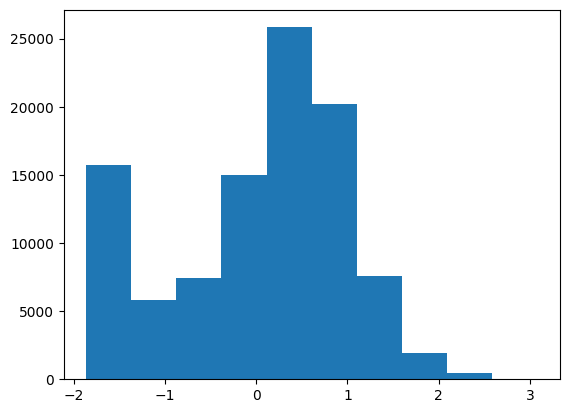

In [106]:
# load data
X2d_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/X2d_sample.npy"), dtype=jnp.float64) # [N, D]
X3d_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/X3d_sample.npy"), dtype=jnp.float64) # [N, D]
Xstatic_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/XStatic_sample.npy"), dtype=jnp.float64) # [N, D]
Y_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/Y_sample.npy"), dtype=jnp.float64) # [N, 1]
pressure = jnp.array([[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,60000,70000,80000, 85000,90000,92500,95000,97500,100000]], dtype=jnp.float64)
pressure_mean = jnp.mean(pressure)
pressure_std = jnp.std(pressure)
pressure = (pressure - pressure_mean) / pressure_std



# random shuffle
X2d = jr.permutation(key, X2d_raw)
X3d = jr.permutation(key, X3d_raw)
Xstatic = jr.permutation(key, Xstatic_raw)
Y = jr.permutation(key, Y_raw)

# look at ERA5 rain
Y = Y[:,0:1]  




# just keep the "prognostic" 3d inputs that joe considered (for now)
# RH, tehta_e^+, theta_e, theta_e^*
names_3d =  ["K,","RH", "q", "gh", "wind_z","wind_m","theta","tehta_e", "theta_e+", "theta_e*", "plume"]
idx_3d = [i for i in range(len(names_3d))]
# idx_3d = [1, 7, 8, 9]
names_3d = [names_3d[i] for i in idx_3d]
X3d = X3d[:,idx_3d,:]


# # also use his "normalisatopm" for sigma_o
# sigma_o = jnp.where(Xstatic[:,0]<0.5, 0.0, 1.0+jnp.log(1+Xstatic[:,2])) # optimize threshold?
# Xstatic = Xstatic.at[:,2].set(sigma_o)
names_static = ["LSM","O_angle","O_sd","O_slope"]
idx_static = [i for i in range(len(names_static))]
# idx_static = [0]
#idx_static = []
names_static = [names_static[i] for i in idx_static]
Xstatic = Xstatic[:,idx_static]


names_2d = ["K_surface","flux_s","flux_l","moisture","CRH"]
idx_2d =[i for i in range(len(names_2d))]
idx_2d = [1,2,3,4]
names_2d = [names_2d[i] for i in idx_2d]
X2d = X2d[:,idx_2d]


#remove all pressure levels above 500 hPA
lowest_idx =  11 #7
print(f"Removed all pressure levels below {pressure[:,lowest_idx]} hPa")
X3d = X3d[:, :, lowest_idx:]
pressure_levels = pressure[:,lowest_idx:]



# remove any entries with nan
X3d_nan_idx = jnp.isnan(X3d).any(axis=1).any(axis=1)
X2d_nan_idx = jnp.isnan(X2d).any(axis=1)
Xstatic_nan_idx = jnp.isnan(Xstatic).any(axis=1)
Y_nan_idx = jnp.isnan(Y).any(axis=1)
any_nan = X3d_nan_idx | X2d_nan_idx | Y_nan_idx | Xstatic_nan_idx
no_nan = ~ any_nan
print(f"Removed {any_nan.sum()} entries with nan")
X2d = X2d[no_nan,:]
X3d = X3d[no_nan,:,:]
Xstatic = Xstatic[no_nan,:]
Y = Y[no_nan,:]


# # remove no rain days
# print(f"Removed {(Y[:,0]==0).sum()} entries with zero rain")
# X3d = X3d[Y[:,0]>0,:]
# X2d = X2d[Y[:,0]>0,:]
# Xstatic = Xstatic[Y[:,0]>0,:]
# Y = Y[Y[:,0]>0,:]


# also log Y
# print(f"Applied log transform to Y")
Y = jnp.log(Y-jnp.min(Y)+1e-1)
print(f"then standardized Y as Gaussian")
Y_mean = jnp.mean(Y)
Y_std = jnp.std(Y)
Y = (Y - Y_mean) / Y_std
plt.hist(Y.T)


#standardize inputs 
print("standardized inputs to be Gaussian")
# X3d_before_standardization = X3d
# X3d_mean = jnp.mean(X3d,axis=(0))
# #X3d_std = jnp.std(X3d, axis=(0,2))
# #X3d = (X3d - X3d_mean[None,:,:]) / X3d_std[None,:,None]
# X3d_std = jnp.std(X3d, axis=(0))
# X3d = (X3d - X3d_mean[None,:,:]) / X3d_std[None,:,:]
# X2d_std = jnp.std(X2d, axis=0)
# X2d_mean = jnp.mean(X2d,axis=0)
# X2d = (X2d - X2d_mean) / X2d_std
# Xstatic_std = jnp.std(Xstatic, axis=0)
# Xstatic_mean = jnp.mean(Xstatic,axis=0)
# Xstatic = (Xstatic - Xstatic_mean) / Xstatic_std





print("standardized inputs with max and min")
X3d_before_standardization = X3d
X3d_min = jnp.min(X3d, axis=(0))
X3d_max = jnp.max(X3d,axis=(0))
X3d = (X3d_max - X3d) / (X3d_max - X3d_min)
X2d_min = jnp.min(X2d, axis=0)
X2d_max = jnp.max(X2d,axis=0)
X2d = (X2d_max - X2d) / (X2d_max - X2d_min)
Xstatic_min = jnp.min(Xstatic, axis=0)
Xstatic_max = jnp.max(Xstatic,axis=0)
Xstatic = (Xstatic_max - Xstatic) / (Xstatic_max - Xstatic_min)





# look at all data but 1_000 test

N_test = 100
N_train = len(X2d) - N_test 
print(f"Using {N_train} training and {N_test} testing points!")
num_2d_variables= X2d.shape[1]
num_3d_variables= X3d.shape[1]
num_static_variables= Xstatic.shape[1]
num_not_3d_variables = num_2d_variables + num_static_variables
num_variables = num_2d_variables + num_3d_variables + num_static_variables
print(f"using {num_static_variables} static variables")
print(f"using {num_2d_variables} 2d variables")
print(f"using {num_3d_variables} 3d variables")
names = names_3d + names_2d + names_static
print(f"using variables with names {names}")

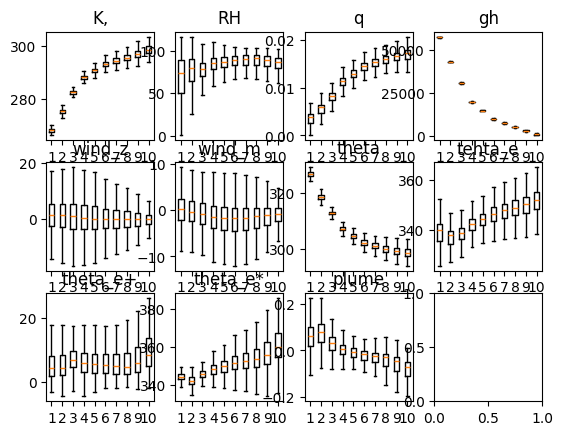

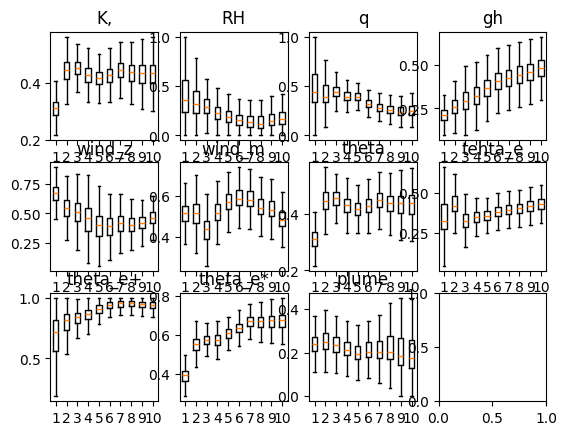

In [107]:
for data in [X3d_before_standardization, X3d]:
    fig, ax = plt.subplots(nrows=3, ncols=4)
    i,j=0,0
    for row in ax:
        for col in row:
            col.boxplot(data[:,i,:].T, showfliers=False);
            col.set_title(names_3d[i])
            i+=1
            if i==data.shape[1]:
                break
        if i==data.shape[1]:
            break


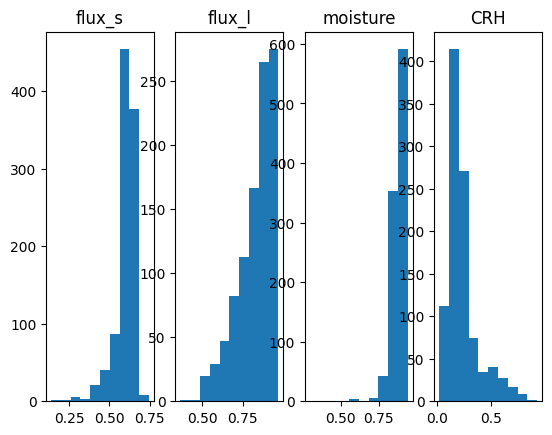

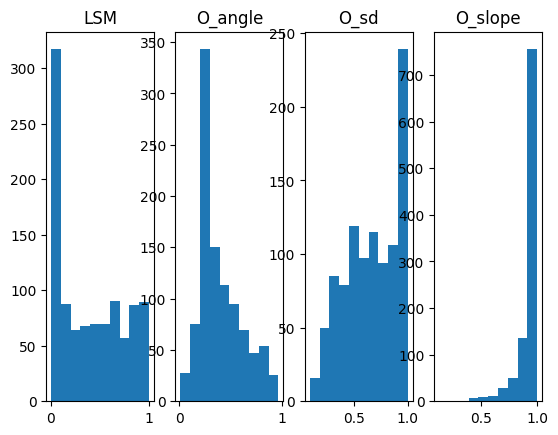

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=num_2d_variables)
i=0
for col in ax:
    col.hist(X2d[:1000,i].T);
    col.set_title(names_2d[i])
    i+=1
fig, ax = plt.subplots(nrows=1, ncols=num_static_variables)
i=0
for col in ax:
    col.hist(Xstatic[:1000,i].T);
    col.set_title(names_static[i])
    i+=1

In [111]:
def plot_params(model, title=""):
    if isinstance(model, gpx.variational_families.AbstractVariationalFamily):
        model = model.posterior
    plt.figure()
    if isinstance(model.prior.kernel, gpx.kernels.AdditiveKernel):
        lengthscales = jnp.array([model.prior.kernel.kernels[i].lengthscale[0] for i in range(len(model.prior.kernel.kernels))])
    else:
        lengthscales = model.prior.kernel.lengthscale
        
    z_to_plot = jnp.linspace(jnp.min(model.smoother.Z_levels),jnp.max(model.smoother.Z_levels),100)
    smoothing_weights = model.smoother.smooth_fn(z_to_plot) 
    z_unscaled = z_to_plot * pressure_std+ pressure_mean
    for i in range(num_3d_variables):
        plt.plot(smoothing_weights[i,:].T,z_unscaled, label=f"{names_3d[i]} with lengthscales_ {lengthscales[i]:.2f}")
    plt.legend()
    plt.title(title+f" other lengthscales are {lengthscales[num_3d_variables:]}")


def plot_interactions(model, data, k=10):
    plt.figure()
    idx_2 = []
    for i in range(num_variables):
        for j in range(i+1,num_variables):
            idx_2.append([i,j])
    idxs = [[]] + [[i] for i in range(num_variables)] + idx_2
    if isinstance(model, gpx.variational_families.AbstractVariationalFamily):
        sobols = model.get_sobol_indicies(idxs)
        z = model.inducing_inputs
        posterior_dist = model.predict_additive_component(z[:1,:],[])
    else:
        sobols = model.get_sobol_indicies(data, idxs)
        z = model.smoother.smooth_data(data)[0]
        posterior_dist = model.predict_additive_component(z[:1,:], data, [])
    sobols = sobols / jnp.sum(sobols)
    plt.plot(sobols)
    plt.title("sobol indicies (red lines between orders)")
    plt.axvline(x=1, color="red")
    plt.axvline(x=num_variables+1, color="red")
    print(f"cst term is {posterior_dist.mean() * Y_std + Y_mean}")
    for idx in jax.lax.top_k(sobols, k)[1]:
        chosen_idx = idxs[idx]
        plt.figure()
        num_plot = 1_000 if len(chosen_idx)==1 else 10_000
        x_plot = jr.uniform(key, (num_plot, num_variables), minval=jnp.min(z, axis=0), maxval=jnp.max(z, axis=0))
        if isinstance(model, gpx.variational_families.AbstractVariationalFamily):
            posterior_dist = model.predict_additive_component(x_plot,chosen_idx)
        else:
            posterior_dist = model.predict_additive_component(x_plot, data, chosen_idx)
        mean = posterior_dist.mean() * Y_std + Y_mean
        std = jnp.sqrt(posterior_dist.variance())* Y_std
        if len(chosen_idx)==1:
            plt.scatter(x_plot[:,chosen_idx[0]],mean, color="blue") 
            plt.scatter(x_plot[:,chosen_idx[0]],mean+ 1.96*std, color="red") 
            plt.scatter(x_plot[:,chosen_idx[0]],mean- 1.96*std, color="red") 
            plt.xlim([jnp.min(z[:,chosen_idx[0]]),jnp.max(z[:,chosen_idx[0]])])
            plt.scatter(z[:,chosen_idx[0]],jnp.zeros_like(z[:,chosen_idx[0]]), color="black")
        elif len(chosen_idx)==2:
            col = plt.scatter(x_plot[:,chosen_idx[0]],x_plot[:,chosen_idx[1]],c=mean)
            plt.ylim([jnp.min(z[:,chosen_idx[1]]),jnp.max(z[:,chosen_idx[1]])])
            plt.colorbar(col)
            plt.scatter(z[:,chosen_idx[0]],z[:,chosen_idx[1]], color="black")
        plt.xlim([jnp.min(z[:,chosen_idx[0]]),jnp.max(z[:,chosen_idx[0]])])   
        plt.title(f"variable {[names[i] for i in chosen_idx]} with sobol index {sobols[idx]}")



In [112]:
def build_log_prior(tau=None) -> callable:

    def log_prior(model):
        log_prob = 0.0

        # if hasattr(model, "smoother"):
        #     smoother_input_scale_prior = tfd.LogNormal(0.0,1.0)
        #     smoother_mean_prior = tfd.Uniform(jnp.min(model.smoother.Z_levels),jnp.max(model.smoother.Z_levels))
        #     log_prob += jnp.sum(smoother_mean_prior.log_prob(model.smoother.smoother_mean))
        #     log_prob += jnp.sum(smoother_input_scale_prior.log_prob(model.smoother.smoother_input_scale))


        if isinstance(model.prior.kernel, AdditiveKernel):
            lengthscales = jnp.vstack([k.lengthscale for k in model.prior.kernel.kernels])
            variances = model.prior.kernel.interaction_variances
        else:
            lengthscales = model.prior.kernel.lengthscale
            variances = model.prior.kernel.variance
            
        variance_prior = tfd.Gamma(1.0,0.2)
        log_prob += jnp.sum(variance_prior.log_prob(variances))

        d = lengthscales.size
        #l_prior = tfd.LogNormal(jnp.sqrt(2.0) + jnp.log(d)/2.0,jnp.sqrt(1.0))
        #l_prior = tfd.Gamma(3.0*d,6.0)
        #l_prior = tfd.Gamma(3.0,6.0/d)
        #log_prob += jnp.sum(l_prior.log_prob(lengthscales))
        # #l_prior = tfd.HalfCauchy(0.0,tau)
        # #log_prob += jnp.sum(l_prior.log_prob((1.0 / lengthscales**2)))

            
        noise_prior = tfd.LogNormal(0.0,10)
        log_prob += noise_prior.log_prob(model.likelihood.obs_stddev)




        return log_prob
    
    return log_prior



def init_smoother(data: VerticalDataset, fit=True, tau=0.1, verbose=False) -> VerticalSmoother:
    smoother_input_scale_bijector = tfb.Softplus(low=jnp.array(1e-1, dtype=jnp.float64))
    smoother_mean_bijector =  tfb.SoftClip(low=jnp.min(pressure_levels), high=jnp.max(pressure_levels))

    if fit:
        kernels = []
        smoothers = []
        likelihoods = []
        scores = []
        for i in range(num_3d_variables):
            print(f"doing the {i} input")
            scores_i = []
            kernels_i = []
            likelihoods_i = []
            smoothers_i = []
            for j in range(1,len(pressure_levels[0])):
                smoother_input_scale = 2.0
                smoother_mean = pressure_levels[0][j]
                smoother_i = VerticalSmoother(
                    jnp.array([[smoother_mean]]), jnp.array([[smoother_input_scale]]), Z_levels=pressure_levels
                    ).replace_bijector(smoother_input_scale=smoother_input_scale_bijector, smoother_mean=smoother_mean_bijector).replace_trainable(smoother_mean=False)
                data_i = VerticalDataset(X3d=data.X3d[:,i:i+1,:]  ,X2d = jnp.array([[]]*len(data.X3d)),Xstatic = jnp.array([[]]*len(data.X3d)), y = data.y)
                posterior_i = CustomAdditiveConjugatePosterior(
                    prior= init_prior(data_i), 
                    likelihood=init_likelihood(data_i),
                    smoother=smoother_i,
                    )
                obj_i = CustomConjugateMLL(negative=True, log_prior=build_log_prior(tau))
                opt_posterior_i, history_i = gpx.fit_scipy(model=posterior_i,objective=obj_i,train_data=data_i,safe=False, verbose=False)
                if verbose:
                    print("##################################")
                    print(f"found loss is {history_i[-1]}")
                    print(f"lengthscale is {opt_posterior_i.prior.kernel.kernels[0].lengthscale} and variance is {opt_posterior_i.prior.kernel.interaction_variances[1]} and noise is {opt_posterior_i.likelihood.obs_stddev}")
                    print(f"smoother mean is {opt_posterior_i.smoother.smoother_mean} and smoother input scale is {opt_posterior_i.smoother.smoother_input_scale}")
                scores_i.append(history_i[-1])
                smoothers_i.append(opt_posterior_i.smoother)
                kernels_i.append(opt_posterior_i.prior.kernel)
                likelihoods_i.append(opt_posterior_i.likelihood)
            best_idx = jnp.nanargmin(jnp.array(scores_i))
            smoothers.append(smoothers_i[best_idx])
            kernels.append(kernels_i[best_idx])
            likelihoods.append(likelihoods_i[best_idx])
            scores.append(scores_i[best_idx])


        smoother = VerticalSmoother(
            jnp.array([[s.smoother_mean[0,0] for s in smoothers]]), 
            jnp.array([[s.smoother_input_scale[0][0] for s in smoothers]]), 
            Z_levels=pressure_levels
        ).replace_bijector(smoother_input_scale=smoother_input_scale_bijector,smoother_mean=smoother_mean_bijector).replace_trainable(smoother_mean=False)

        z_to_plot = jnp.linspace(jnp.min(smoother.Z_levels),jnp.max(smoother.Z_levels),100)
        smoothing_weights = smoother.smooth_fn(z_to_plot) 
        z_unscaled = z_to_plot * pressure_std+ pressure_mean
        for i in range(num_3d_variables):
            plt.plot(smoothing_weights[i,:].T,z_unscaled, label=f"{names_3d[i]} with l {kernels[i].kernels[0].lengthscale}, v {kernels[i].interaction_variances[1]}, n {likelihoods[i].obs_stddev}, s {scores[i]}")
        plt.legend(loc='upper center', bbox_to_anchor=(1.0, 1.05))
    else:
        smoother = VerticalSmoother(
            jnp.array([[1.0]*num_3d_variables]), 
            jnp.array([[1.0]*num_3d_variables]), 
            Z_levels=pressure_levels
            ).replace_bijector(smoother_input_scale=smoother_input_scale_bijector,smoother_mean=smoother_mean_bijector)
    return smoother


def init_prior(data):
    lengthscale_bij = tfb.Softplus(low=jnp.array(1e-3, dtype=jnp.float64))
    variance_bij =  tfb.Softplus(low=jnp.array(1e-3, dtype=jnp.float64))
    
    #base_kernels = [gpx.kernels.RBF(lengthscale=jnp.array([1.0]), active_dims=[i]).replace_trainable(variance=False).replace_bijector(lengthscale = lengthscale_bij) for i in range(num_variables)]
    #base_kernels= [OrthogonalRBF(lengthscale=jnp.array([1.]), active_dims=[i]).replace_bijector(lengthscale = lengthscale_bij) for i in range(data.dim)]
    base_kernels= [OrthogonalRBFUnif(lengthscale=jnp.array([1.]), active_dims=[i]).replace_bijector(lengthscale = lengthscale_bij) for i in range(data.dim)]
    max_interaction = 2
    max_interaction = min(max_interaction, data.dim)
    zeroth_order = False
    kernel = gpx.kernels.AdditiveKernel(kernels=base_kernels,interaction_variances=jnp.array([1.0]*(max_interaction+1*zeroth_order)), max_interaction_depth=max_interaction, zeroth_order=zeroth_order).replace_bijector(
        interaction_variances=variance_bij,
        )
    return gpx.gps.Prior(mean_function= gpx.mean_functions.Zero(), kernel = kernel)


def init_likelihood(data):
    obs_bij=tfb.Softplus(low=jnp.array(1e-2, dtype=jnp.float64))
    return gpx.likelihoods.Gaussian(num_datapoints=data.n, obs_stddev=jnp.array(0.1, dtype=jnp.float64)).replace_bijector(obs_stddev=obs_bij)





doing the 0 input


/Users/henry/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1475: RuntimeWarning: invalid value encountered in scalar multiply
  if (alpha_k*vecnorm(pk) <= xrtol*(xrtol + vecnorm(xk))):


doing the 1 input


/Users/henry/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1475: RuntimeWarning: invalid value encountered in scalar multiply
  if (alpha_k*vecnorm(pk) <= xrtol*(xrtol + vecnorm(xk))):
/Users/henry/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1475: RuntimeWarning: invalid value encountered in scalar multiply
  if (alpha_k*vecnorm(pk) <= xrtol*(xrtol + vecnorm(xk))):


doing the 2 input


/Users/henry/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1475: RuntimeWarning: invalid value encountered in scalar multiply
  if (alpha_k*vecnorm(pk) <= xrtol*(xrtol + vecnorm(xk))):


doing the 3 input


/Users/henry/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1475: RuntimeWarning: invalid value encountered in scalar multiply
  if (alpha_k*vecnorm(pk) <= xrtol*(xrtol + vecnorm(xk))):


doing the 4 input


/Users/henry/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1475: RuntimeWarning: invalid value encountered in scalar multiply
  if (alpha_k*vecnorm(pk) <= xrtol*(xrtol + vecnorm(xk))):


doing the 5 input


/Users/henry/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1475: RuntimeWarning: invalid value encountered in scalar multiply
  if (alpha_k*vecnorm(pk) <= xrtol*(xrtol + vecnorm(xk))):


doing the 6 input


/Users/henry/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1475: RuntimeWarning: invalid value encountered in scalar multiply
  if (alpha_k*vecnorm(pk) <= xrtol*(xrtol + vecnorm(xk))):


doing the 7 input


/Users/henry/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1475: RuntimeWarning: invalid value encountered in scalar multiply
  if (alpha_k*vecnorm(pk) <= xrtol*(xrtol + vecnorm(xk))):


doing the 8 input


/Users/henry/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1475: RuntimeWarning: invalid value encountered in scalar multiply
  if (alpha_k*vecnorm(pk) <= xrtol*(xrtol + vecnorm(xk))):


doing the 9 input


/Users/henry/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1475: RuntimeWarning: invalid value encountered in scalar multiply
  if (alpha_k*vecnorm(pk) <= xrtol*(xrtol + vecnorm(xk))):


doing the 10 input


/Users/henry/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1475: RuntimeWarning: invalid value encountered in scalar multiply
  if (alpha_k*vecnorm(pk) <= xrtol*(xrtol + vecnorm(xk))):
/Users/henry/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1475: RuntimeWarning: invalid value encountered in scalar multiply
  if (alpha_k*vecnorm(pk) <= xrtol*(xrtol + vecnorm(xk))):
/Users/henry/miniconda3/envs/gpjax/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 93.365778
         Iterations: 263
         Function evaluations: 380
         Gradient evaluations: 369
noise is 0.2758498477664169
interaction vars [0.001      0.08159698]


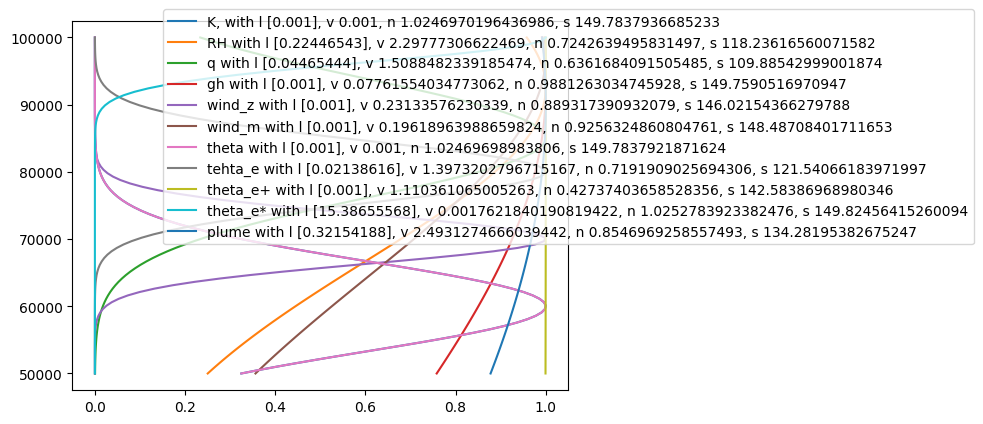

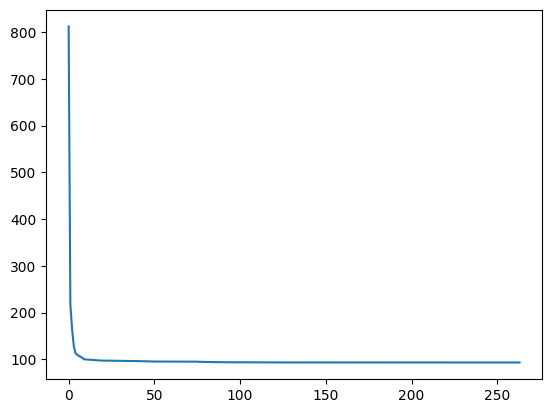

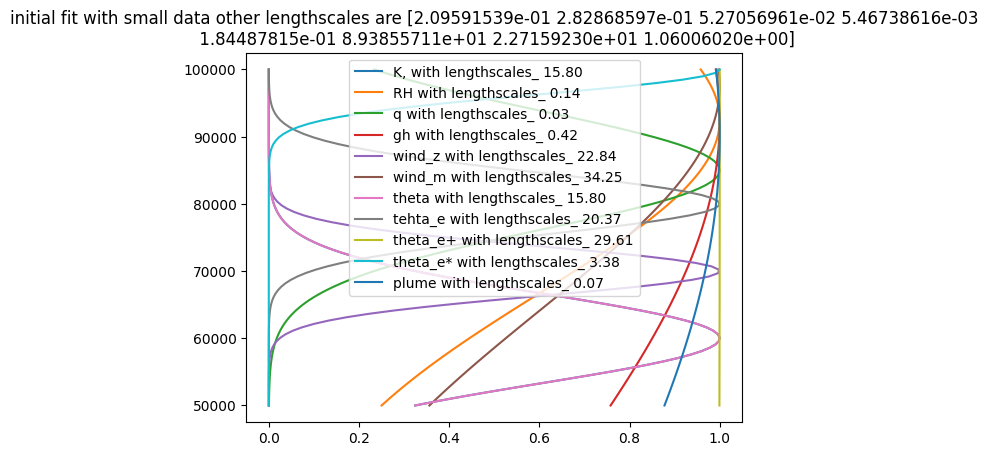

In [113]:
# prep fancy kernel for model
# first fit with small data to get init for SVGP
num_data_for_init=100
D_small = VerticalDataset(
    X2d = X2d[:num_data_for_init,:],
    X3d = X3d[:num_data_for_init,:,:],
    Xstatic = Xstatic[:num_data_for_init,:],
    y=Y[:num_data_for_init,:],
)



smoother = init_smoother(D_small, fit=True, verbose=False)
smoother = smoother.replace_trainable(smoother_input_scale=False, smoother_mean=False)

# fit with small data

posterior = CustomAdditiveConjugatePosterior(
    prior=init_prior(D_small), 
    likelihood=init_likelihood(D_small), 
    smoother=smoother,
    )
plt.figure()
# opt_posterior, history = gpx.fit(
#         model=posterior,
#         objective=jax.jit(CustomConjugateMLL(negative=True, log_prior=build_log_prior())),
#         train_data=D_small,
#         optim=ox.adamw(1e-1),
#         num_iters=1000,
#         key=jr.PRNGKey(42),
#         safe=False,
#     )
opt_posterior, history = gpx.fit_scipy(
        model=posterior,
        objective=jax.jit(CustomConjugateMLL(negative=True, log_prior=build_log_prior())),
        train_data=D_small,
        safe=False,
    )
plt.plot(history)
plot_params(opt_posterior, title="initial fit with small data")
print(f"noise is {opt_posterior.likelihood.obs_stddev}")
print(f"interaction vars {opt_posterior.prior.kernel.interaction_variances}")


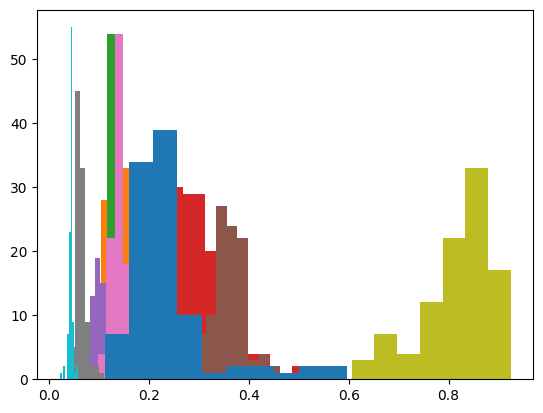

In [115]:
smoothed = opt_posterior.smoother.smooth_data(D_small)[0]
for i in range(num_3d_variables):
    plt.hist(smoothed[:,i])

cst term is [-0.06641895]


<Figure size 640x480 with 0 Axes>

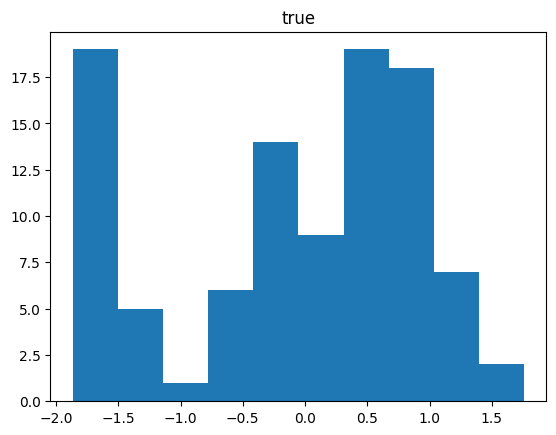

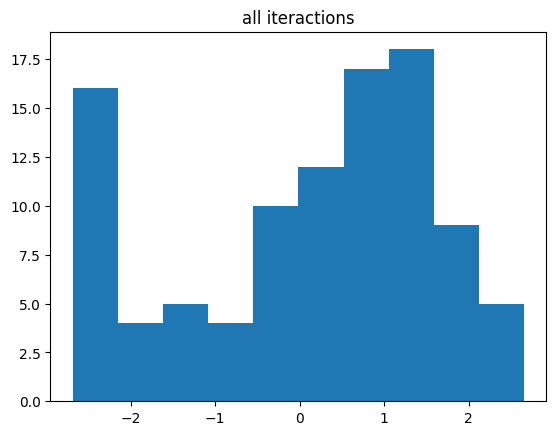

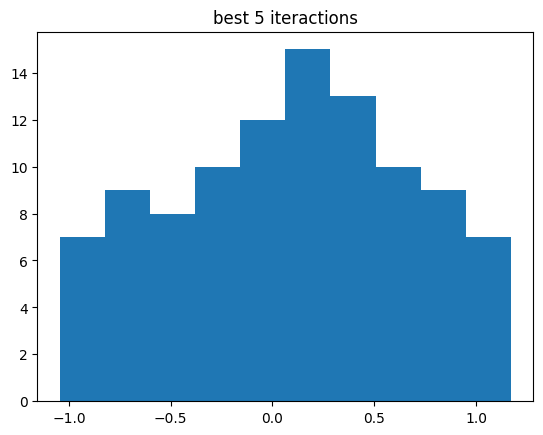

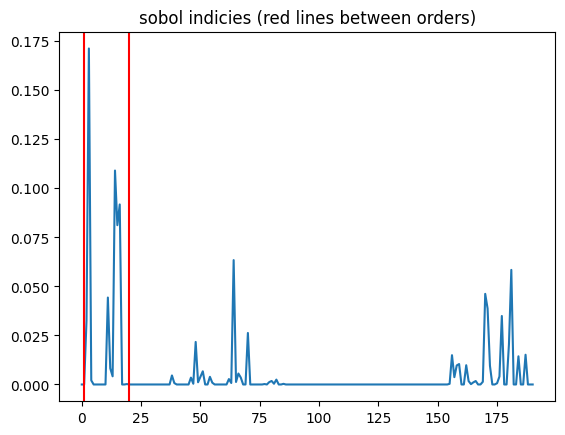

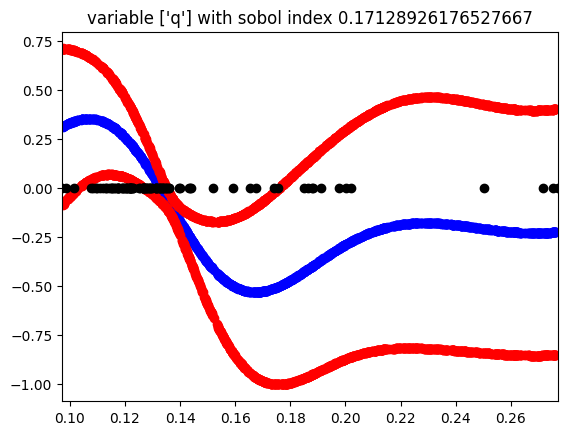

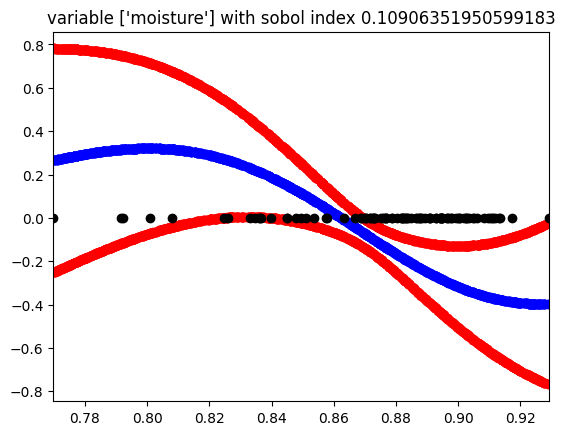

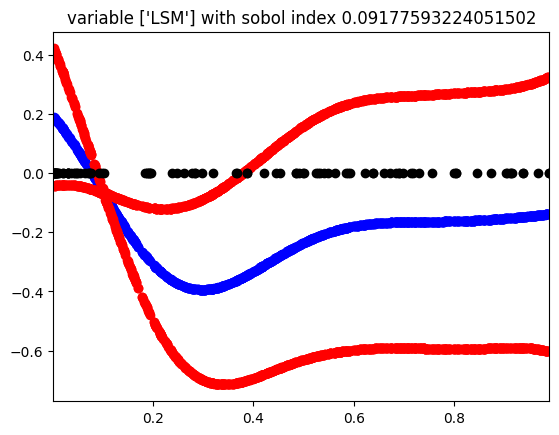

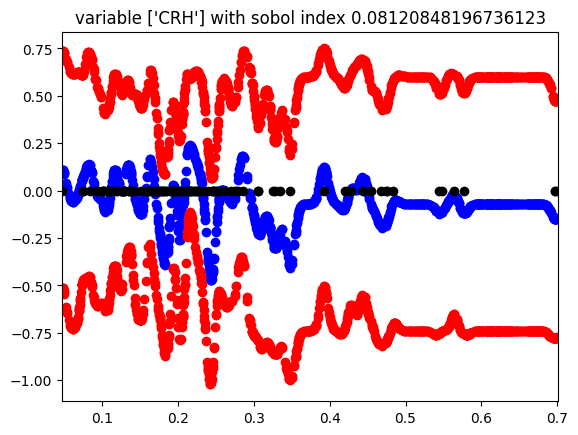

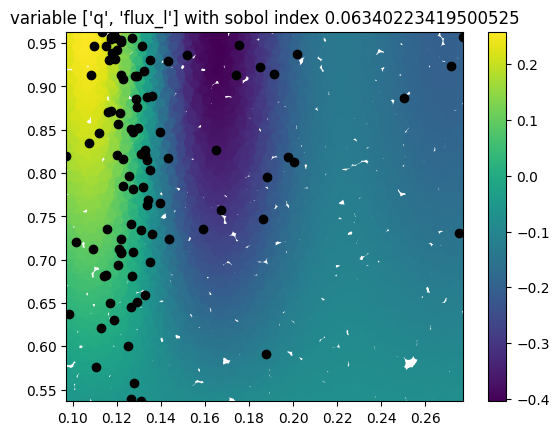

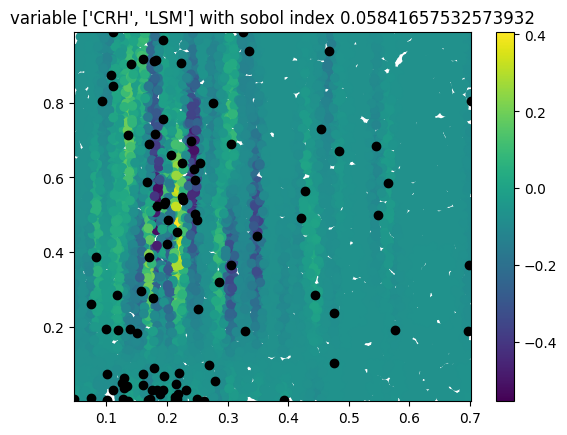

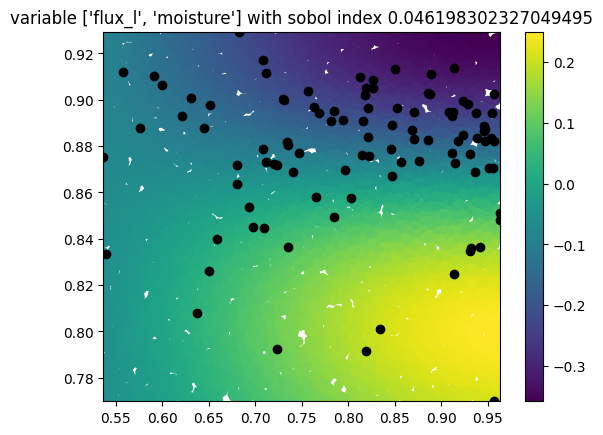

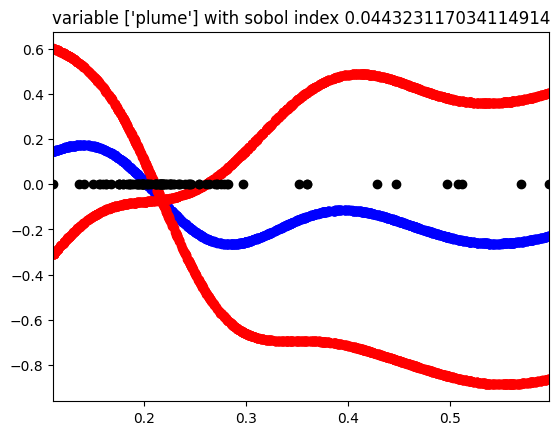

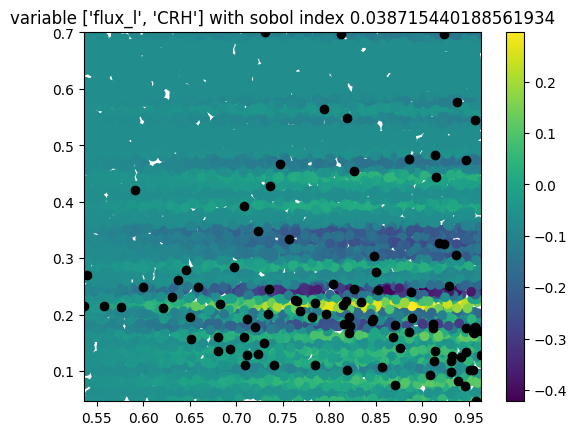

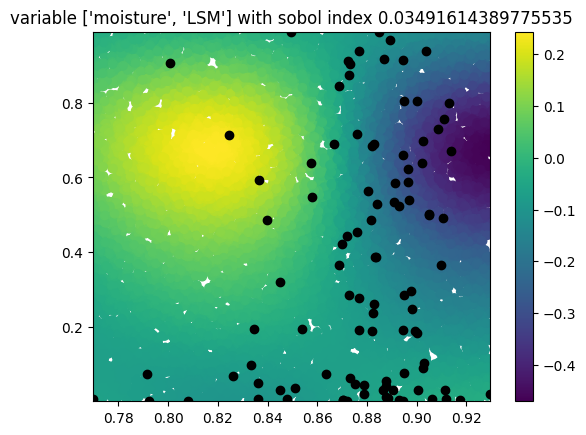

In [116]:
plot_interactions(opt_posterior, D_small)

In [10]:
# # choose inducing inputs and init SVGP
# num_inducing = 10
# #z = jr.normal(key, (num_inducing , num_variables)) # allow this
# z = opt_posterior.smoother.smooth_data(D_small)[0][:num_inducing] # need space filling deisng

# # from scipy.stats import qmc
# # sampler = qmc.Halton(d=num_variables, scramble=False, seed=1234)
# # z_box = sampler.random(n=num_inducing)
# # v = 0.5 + (1 - 1e-10) * (z_box - 0.5)
# # z = jax.scipy.special.erfinv(2 * v - 1) * jnp.sqrt(2)



# init_posterior_at_inducing = opt_posterior.predict(z, D_small)
# D_full = VerticalDataset(
#     X2d = X2d[:N_train,:],
#     X3d = X3d[:N_train,:,:],
#     Xstatic = Xstatic[:N_train,:],
#     y=Y[:N_train,:],
# )
# # todo try whitening ?
# q = CustomVariationalGaussian(
#     posterior=opt_posterior, 
#     inducing_inputs=z,
#     variational_mean= init_posterior_at_inducing.mean()[:,None],
#     variational_root_covariance= jnp.eye(num_inducing, dtype=jnp.float64)#jnp.linalg.cholesky(init_posterior_at_inducing.covariance() + 1e-3 * jnp.eye(num_inducing)), # todo check this is right!
# )

# #q = q.replace_trainable(inducing_inputs=False)
# # q = q.replace_trainable(variational_mean=False)
# # q = q.replace_trainable(variational_root_covariance=False)

# objective = jax.jit(CustomELBO(negative=True))

# optim_pytree = q.replace(
#     posterior = ox.adamw(1e-1), 
#     variational_mean = ox.adamw(1e-2),
#     variational_root_covariance = ox.adamw(1e-2), 
#     inducing_inputs= ox.adamw(1e-1),
#     )

# optim = optim_builder(optim_pytree)

# opt_q, history = gpx.fit(
#     model=q,
#     objective=objective,
#     train_data=D_full,
#     optim=optim,
#     num_iters=1000,
#     key=jr.PRNGKey(42),
#     batch_size=512,
#     safe=False,
# )

# plt.figure()
# plt.plot(jnp.log(history))
# plot_params(opt_q, title="full fit")

In [11]:
# plot_interactions(opt_q, D_small)